**Data Cleaning and Preprocessing**

In [55]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.metrics import classification_report, confusion_matrix





In [56]:
# Load dataset
file_path = "/content/Final_data.csv"
df = pd.read_csv(file_path)

# Drop unnecessary columns
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Convert 'Cases' to numeric
df["Cases"] = pd.to_numeric(df["Cases"], errors="coerce")

# Extract week number from 'week_of_outbreak'
df["week_of_outbreak_num"] = df["week_of_outbreak"].str.extract(r"(\d+)").astype(float)

# Drop 'Deaths' (too many missing values)
if "Deaths" in df.columns:
    df = df.drop(columns=["Deaths"])

# Handle missing values for climate variables
for col in ["Temp", "preci", "LAI"]:
    df[col] = df.groupby(["state_ut", "mon"])[col].transform(
        lambda x: x.fillna(x.median())
    )

# Fill any remaining NaNs
df["Temp"] = df["Temp"].fillna(df["Temp"].median())
df["preci"] = df["preci"].fillna(df["preci"].median())
df["LAI"] = df["LAI"].fillna(df["LAI"].median())
df["Cases"] = df["Cases"].fillna(df["Cases"].median())

# Handle rare diseases
disease_counts = df["Disease"].value_counts()
rare_diseases = disease_counts[disease_counts < 50].index
df["Disease"] = df["Disease"].replace(rare_diseases, "Other")

print(" Cleaned dataset shape:", df.shape)
print(" Missing values:\n", df.isnull().sum())
print(" Disease categories:\n", df["Disease"].value_counts().head())


 Cleaned dataset shape: (8985, 14)
 Missing values:
 week_of_outbreak        0
state_ut                0
district                0
Disease                 0
Cases                   0
day                     0
mon                     0
year                    0
Latitude                0
Longitude               0
preci                   0
LAI                     0
Temp                    0
week_of_outbreak_num    0
dtype: int64
 Disease categories:
 Disease
Acute Diarrhoeal Disease    5126
Dengue                      1619
Chikungunya                  731
Cholera                      666
Malaria                      544
Name: count, dtype: int64


In [57]:
# Save as CSV
df.to_csv("Cleaned_Final_Data.csv", index=False)

print("Cleaned dataset saved as Cleaned_Final_Data.csv")

Cleaned dataset saved as Cleaned_Final_Data.csv


**Data transformation**

In [58]:
# =========================
#  Data Transformation (Encoding + Scaling)
# =========================


# Keep a raw copy for EDA (important: do this right after cleaning, before dropping!)
df_raw = df.copy()

# ---------------------------
# One-Hot Encoding
# ---------------------------
categorical_cols = ["state_ut", "district", "Disease"]

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded = encoder.fit_transform(df_raw[categorical_cols])

# Convert to DataFrame
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df_raw.index
)

# Merge with numeric part
df = df_raw.drop(columns=categorical_cols)
df = pd.concat([df, encoded_df], axis=1)

print(" One-Hot Encoding complete. Shape:", df.shape)

# ---------------------------
# Scaling numeric features
# ---------------------------
num_cols_model = ["Temp", "preci", "LAI",
                  "Latitude", "Longitude", "day", "mon", "year", "week_of_outbreak_num"]

scaler = StandardScaler()
df[num_cols_model] = scaler.fit_transform(df[num_cols_model])   # ✅ use df, not df_fe
joblib.dump(scaler, "scaler.pkl")
print(" Scaling complete and scaler saved!")


 One-Hot Encoding complete. Shape: (8985, 847)
 Scaling complete and scaler saved!


**Exploratory Data Analysis**

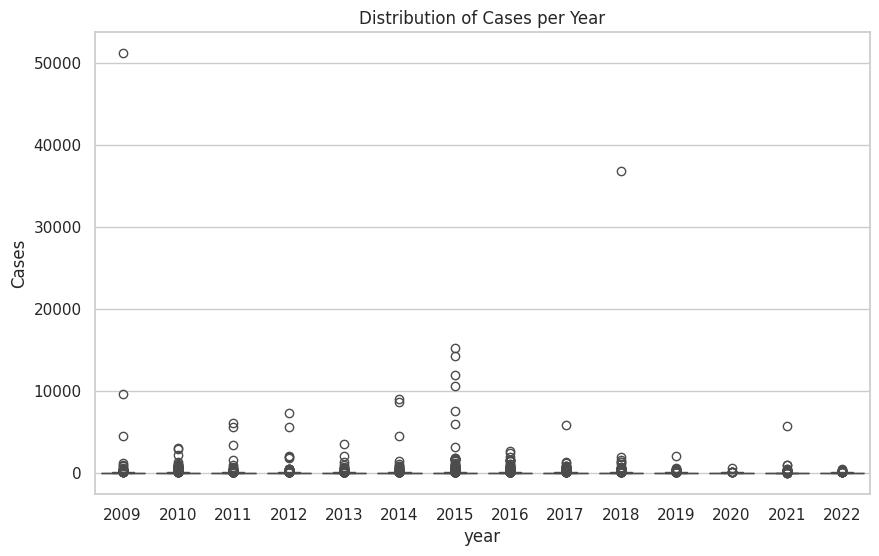

In [59]:
# =========================
#  Exploratory Data Analysis (EDA)
# =========================

# Set style
sns.set(style="whitegrid")

# ---------------------------
#  Cases distribution across years
# ---------------------------
plt.figure(figsize=(10,6))
sns.boxplot(x="year", y="Cases", data=df_raw)
plt.title("Distribution of Cases per Year")
plt.show()





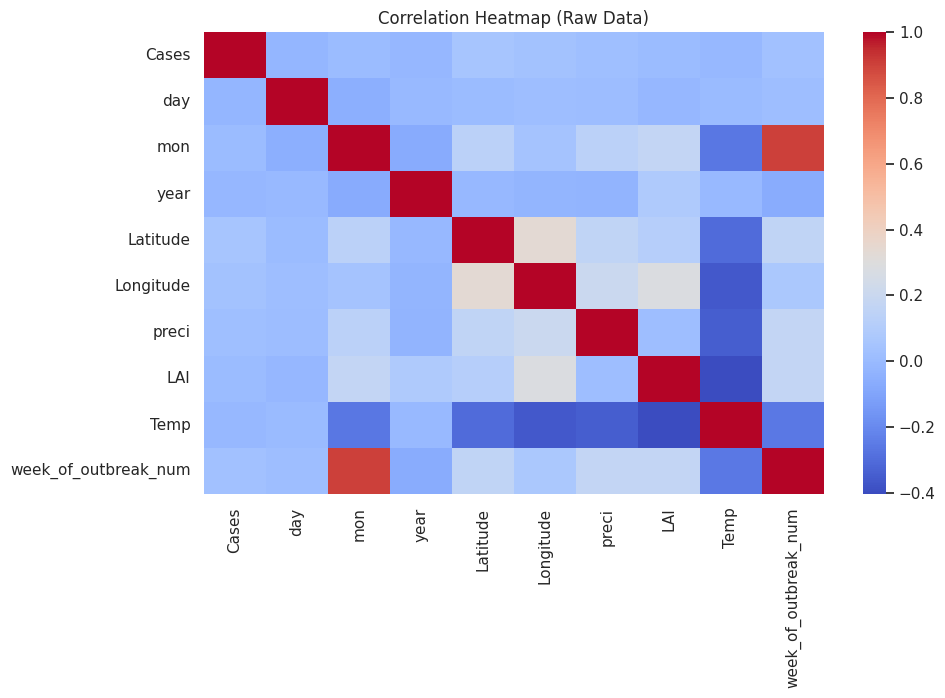

In [60]:
#  Correlation heatmap (numeric features only)
# ---------------------------
plt.figure(figsize=(10,6))
sns.heatmap(df_raw.select_dtypes(include=[np.number]).corr(),
            cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Raw Data)")
plt.show()

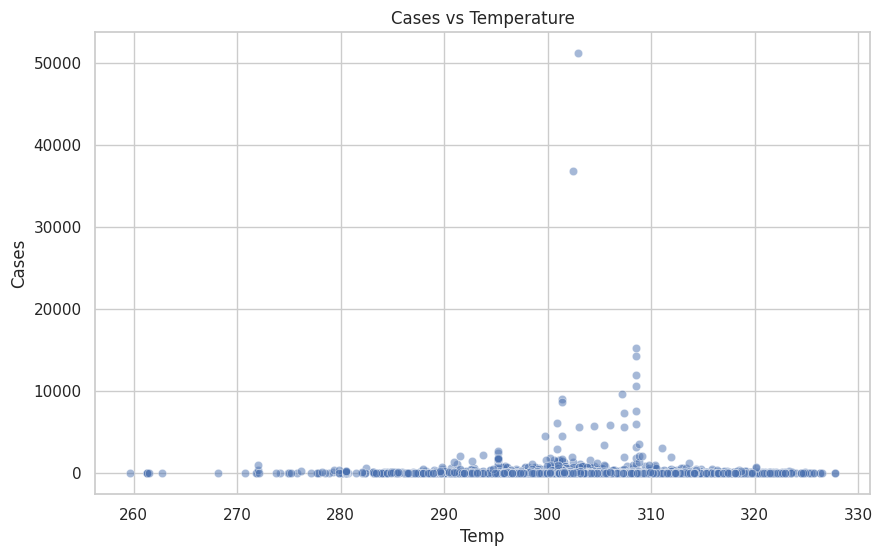

In [61]:
#  Cases vs Temperature (climate influence)
# ---------------------------
plt.figure(figsize=(10,6))
sns.scatterplot(x="Temp", y="Cases", data=df_raw, alpha=0.5)
plt.title("Cases vs Temperature")
plt.show()


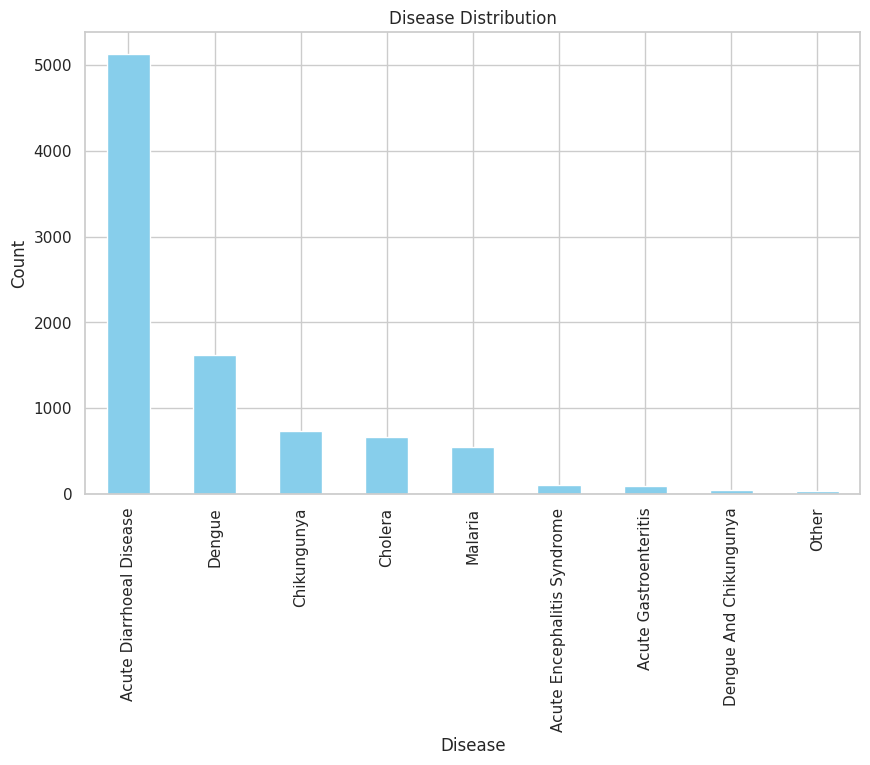

In [62]:
# ---------------------------
#  Disease distribution
# ---------------------------
plt.figure(figsize=(10,6))
df_raw["Disease"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Disease Distribution")
plt.ylabel("Count")
plt.xlabel("Disease")
plt.xticks(rotation=90)
plt.show()


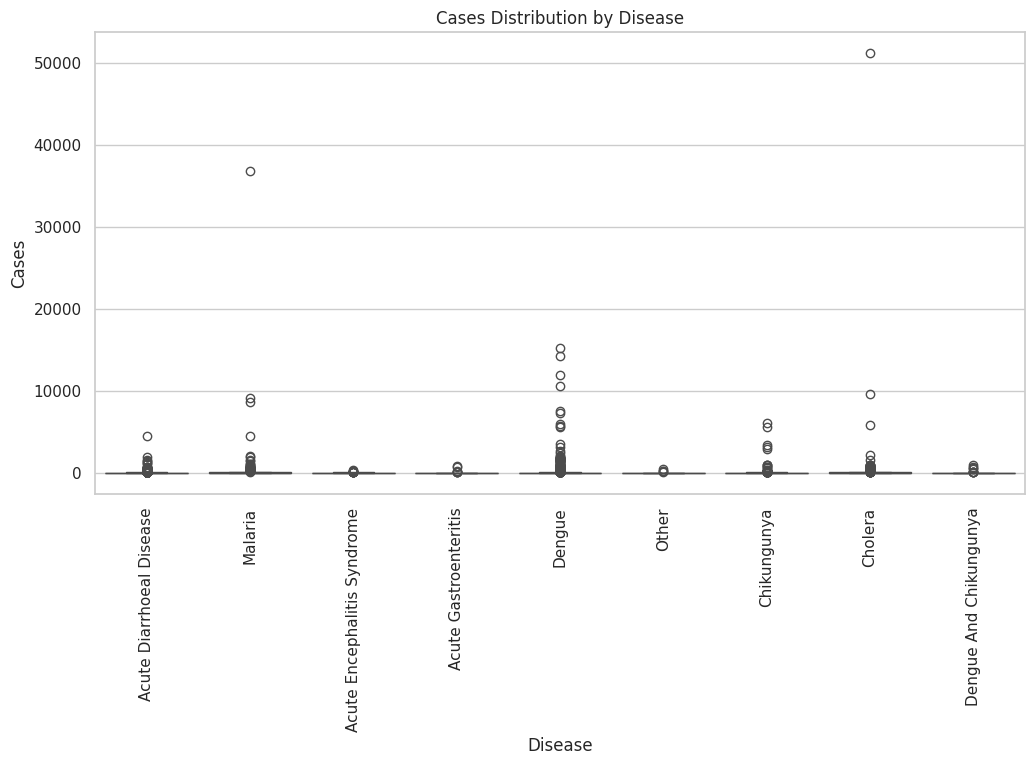

In [63]:
# ---------------------------
#  Cases by Disease
# ---------------------------
plt.figure(figsize=(12,6))
sns.boxplot(x="Disease", y="Cases", data=df_raw)
plt.title("Cases Distribution by Disease")
plt.xticks(rotation=90)
plt.show()

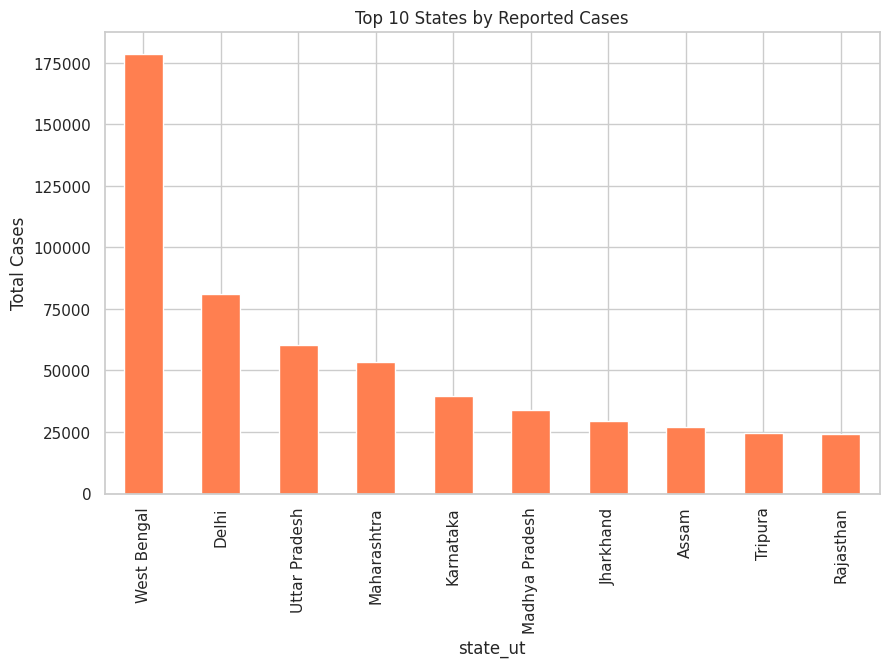

In [64]:
# Top 10 states by total cases
# ---------------------------
top_states = df_raw.groupby("state_ut")["Cases"].sum().sort_values(ascending=False).head(10)
top_states.plot(kind="bar", figsize=(10,6), color="coral")
plt.title("Top 10 States by Reported Cases")
plt.ylabel("Total Cases")
plt.show()


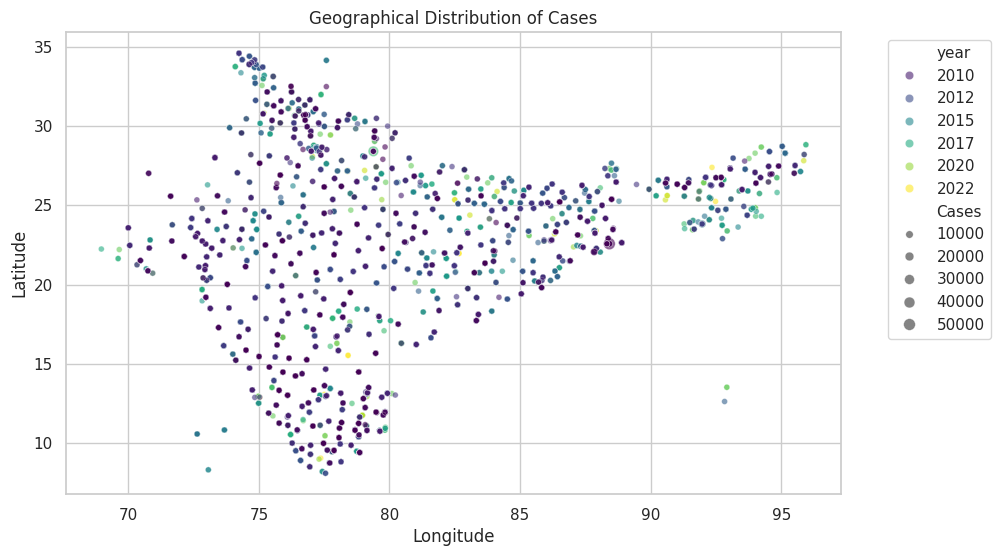

In [65]:
#  Geographical distribution of cases
# ---------------------------
plt.figure(figsize=(10,6))
sns.scatterplot(x="Longitude", y="Latitude", size="Cases", hue="year",
                data=df_raw, alpha=0.6, palette="viridis")
plt.title("Geographical Distribution of Cases")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Feature Engineering**

In [66]:
# Copy raw data
df_fe = df_raw.copy()

# ---------------------------
#  Data Cleaning / Preprocessing
# ---------------------------
# Convert week_of_outbreak to numeric
df_fe['week_of_outbreak_num'] = df_fe['week_of_outbreak'].str.extract(r'(\d+)').astype(int)

df_fe = df_fe.drop(columns=['week_of_outbreak'])

# Handle missing values (example, adjust if needed)
df_fe = df_fe.dropna().reset_index(drop=True)

# ---------------------------
#  Common Transformations
# ---------------------------
# Log-transform Cases
# Log-transform Cases (no clipping)
df_fe["Cases_log"] = np.log1p(df_fe["Cases"])
df_fe["Cases_log_clipped"] = df_fe["Cases_log"]  # keep same column name for consistency


# Sort for temporal consistency
df_fe = df_fe.sort_values(
    by=["state_ut", "district", "year", "week_of_outbreak_num"]
).reset_index(drop=True)

# Seasonal cyclical encoding for week
df_fe["week_sin"] = np.sin(2 * np.pi * df_fe["week_of_outbreak_num"] / 52)
df_fe["week_cos"] = np.cos(2 * np.pi * df_fe["week_of_outbreak_num"] / 52)

# ---------------------------
#  Target 1: Cases Prediction (Regression)
# ---------------------------
# Lag features
for lag in [1, 2, 3]:
    df_fe[f"Cases_lag{lag}"] = (
        df_fe.groupby(["state_ut", "district"])["Cases_log_clipped"].shift(lag)
    )

# Rolling stats
for window in [3, 4, 5]:
    df_fe[f"Cases_roll_mean{window}"] = (
        df_fe.groupby(["state_ut", "district"])["Cases_log_clipped"]
        .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    )
    df_fe[f"Cases_roll_std{window}"] = (
        df_fe.groupby(["state_ut", "district"])["Cases_log_clipped"]
        .transform(lambda x: x.rolling(window=window, min_periods=1).std())
    )

# Cumulative sum + moving median
df_fe["Cases_cumsum"] = df_fe.groupby(["state_ut", "district"])["Cases_log_clipped"].cumsum()
df_fe["Cases_mov_median5"] = df_fe.groupby(["state_ut", "district"])["Cases_log_clipped"].transform(lambda x: x.rolling(window=5, min_periods=1).median())

# Drop NaNs from lags
df_fe = df_fe.dropna().reset_index(drop=True)

print(" Feature Engineering (Cases) complete.")

# ---------------------------
#  Target 2: Disease Classification
# ---------------------------
X_disease = df_fe.drop(columns=["Disease", "Cases", "Cases_log", "Cases_log_clipped"])
y_disease = df_fe["Disease"]

# One-hot encode categorical variables
categorical_cols = ['state_ut', 'district']  # adjust if needed
X_disease = pd.get_dummies(X_disease, columns=categorical_cols, drop_first=True)

# Balance classes with SMOTE
smote = SMOTE(random_state=42)
X_disease_res, y_disease_res = smote.fit_resample(X_disease, y_disease)

print(" Feature Engineering (Disease) complete.")
print("Original distribution:\n", y_disease.value_counts())
print("After SMOTE:\n", y_disease_res.value_counts())

# ---------------------------
#  Target 3: Location Classification
# ---------------------------
X_loc = df_fe.drop(columns=["state_ut", "district", "Disease", "Cases", "Cases_log", "Cases_log_clipped"])
y_state = df_fe["state_ut"]
y_district = df_fe["district"]

print(" Feature Engineering (Location) complete.")
print("States:", y_state.nunique(), "| Districts:", y_district.nunique())


 Feature Engineering (Cases) complete.
 Feature Engineering (Disease) complete.
Original distribution:
 Disease
Acute Diarrhoeal Disease       3821
Dengue                         1379
Chikungunya                     610
Cholera                         555
Malaria                         400
Acute Encephalitis Syndrome      86
Acute Gastroenteritis            83
Dengue And Chikungunya           51
Other                            32
Name: count, dtype: int64
After SMOTE:
 Disease
Acute Diarrhoeal Disease       3821
Cholera                        3821
Chikungunya                    3821
Dengue                         3821
Malaria                        3821
Other                          3821
Acute Encephalitis Syndrome    3821
Dengue And Chikungunya         3821
Acute Gastroenteritis          3821
Name: count, dtype: int64
 Feature Engineering (Location) complete.
States: 33 | Districts: 482


**Feature selection**

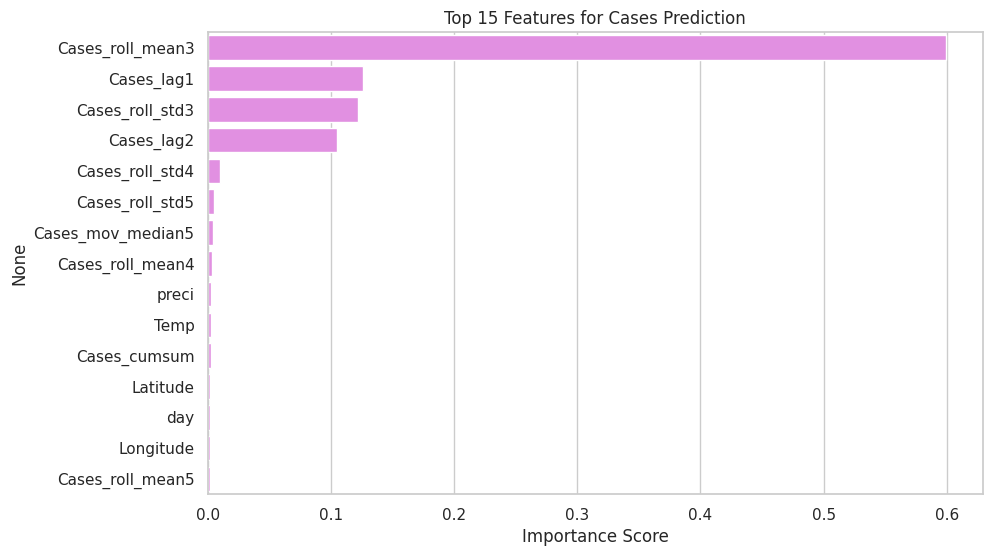

✅ Top features for Cases Prediction:
Cases_roll_mean3     0.599214
Cases_lag1           0.126291
Cases_roll_std3      0.122327
Cases_lag2           0.105230
Cases_roll_std4      0.010049
Cases_roll_std5      0.004699
Cases_mov_median5    0.004378
Cases_roll_mean4     0.003719
preci                0.002518
Temp                 0.002406
Cases_cumsum         0.002354
Latitude             0.001925
day                  0.001765
Longitude            0.001755
Cases_roll_mean5     0.001742
dtype: float64


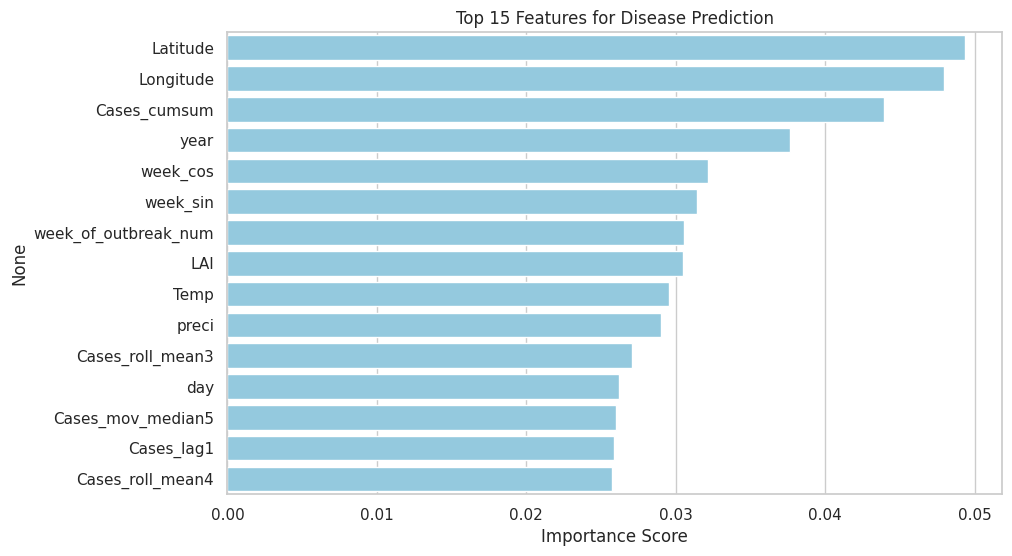

 Top features for Disease Prediction:
Latitude                0.049396
Longitude               0.047927
Cases_cumsum            0.043963
year                    0.037634
week_cos                0.032172
week_sin                0.031413
week_of_outbreak_num    0.030540
LAI                     0.030474
Temp                    0.029587
preci                   0.029052
Cases_roll_mean3        0.027086
day                     0.026189
Cases_mov_median5       0.025993
Cases_lag1              0.025882
Cases_roll_mean4        0.025749
dtype: float64


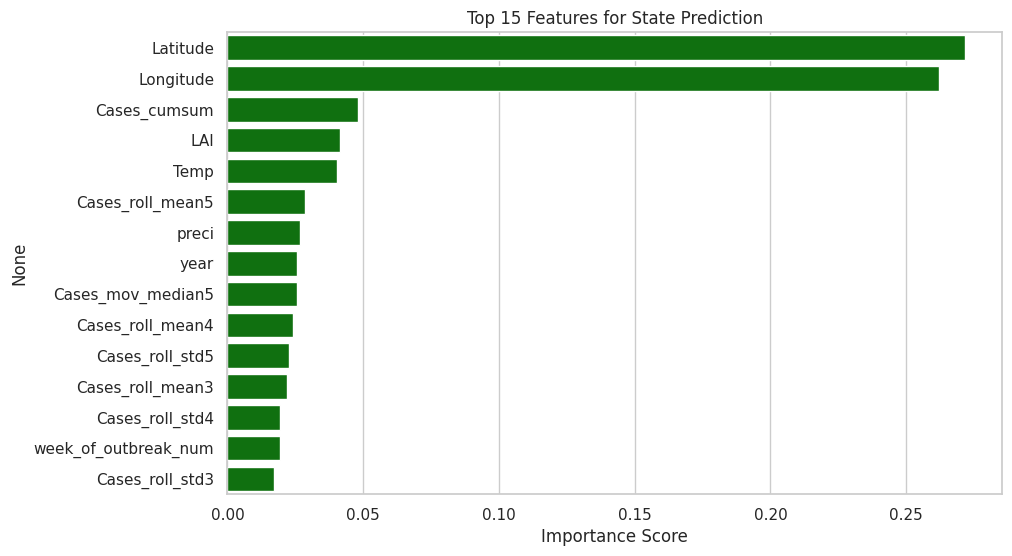

 Top features for State Prediction:
Latitude                0.271818
Longitude               0.262233
Cases_cumsum            0.047976
LAI                     0.041464
Temp                    0.040393
Cases_roll_mean5        0.028688
preci                   0.026804
year                    0.025692
Cases_mov_median5       0.025461
Cases_roll_mean4        0.024293
Cases_roll_std5         0.022699
Cases_roll_mean3        0.021867
Cases_roll_std4         0.019549
week_of_outbreak_num    0.019267
Cases_roll_std3         0.017290
dtype: float64


In [68]:
# ---------------------------
# Feature Selection for Cases Prediction
# ---------------------------
X_cases = df_fe.drop(
    columns=["Cases", "Cases_log", "Cases_log_clipped", "Disease", "state_ut", "district"]
)
y_cases = df_fe["Cases_log_clipped"]

rf_selector_cases = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selector_cases.fit(X_cases, y_cases)

cases_importances = pd.Series(rf_selector_cases.feature_importances_, index=X_cases.columns)
top_cases_features = cases_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_cases_features.values, y=top_cases_features.index, color="violet")
plt.title("Top 15 Features for Cases Prediction")
plt.xlabel("Importance Score")
plt.show()

print("✅ Top features for Cases Prediction:")
print(top_cases_features)

# ---------------------------
# Feature Selection for Disease Prediction
# ---------------------------
rf_selector_disease = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector_disease.fit(X_disease_res, y_disease_res)

disease_importances = pd.Series(rf_selector_disease.feature_importances_, index=X_disease_res.columns)
top_disease_features = disease_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_disease_features.values, y=top_disease_features.index, color="skyblue")
plt.title("Top 15 Features for Disease Prediction")
plt.xlabel("Importance Score")
plt.show()

print(" Top features for Disease Prediction:")
print(top_disease_features)

# ---------------------------
# Feature Selection for Location Prediction (State)
# ---------------------------
rf_selector_state = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector_state.fit(X_loc, y_state)

state_importances = pd.Series(rf_selector_state.feature_importances_, index=X_loc.columns)
top_state_features = state_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_state_features.values, y=top_state_features.index, color="green")
plt.title("Top 15 Features for State Prediction")
plt.xlabel("Importance Score")
plt.show()

print(" Top features for State Prediction:")
print(top_state_features)


**Cases Prediction Model**

XGBoost Regression Results
RMSE: 0.1465
R² Score: 0.9787


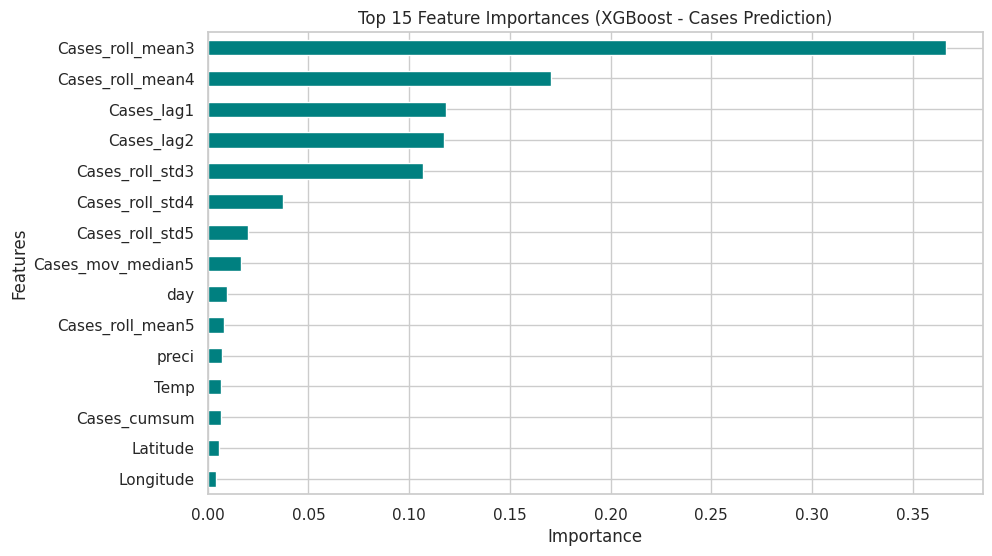

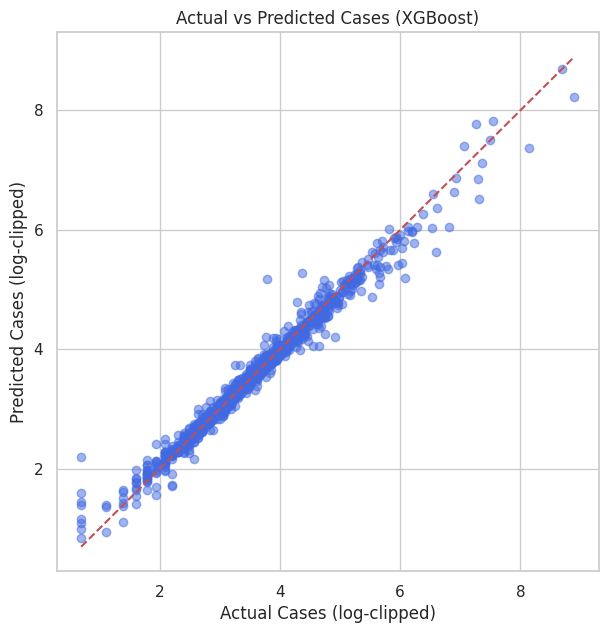

In [69]:
# ---------------------------
# Select top features from previous step
# ---------------------------
X_cases_final = X_cases[top_cases_features.index]  # only important features
y_cases_final = y_cases

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cases_final, y_cases_final, test_size=0.2, random_state=42
)

# ---------------------------
# Train XGBoost Regressor
# ---------------------------
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# ---------------------------
# Predictions & Evaluation
# ---------------------------
y_pred = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("XGBoost Regression Results")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# ---------------------------
# Feature Importance Plot
# ---------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_cases_final.columns)
xgb_importances.sort_values(ascending=False).head(15).plot(kind="barh", color="teal")
plt.title("Top 15 Feature Importances (XGBoost - Cases Prediction)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

# ---------------------------
# Scatter plot: Actual vs Predicted
# ---------------------------
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.5, color="royalblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Cases (log-clipped)")
plt.ylabel("Predicted Cases (log-clipped)")
plt.title("Actual vs Predicted Cases (XGBoost)")
plt.show()


**Disease Prediction Model**

 Disease Prediction Results
                             precision    recall  f1-score   support

   Acute Diarrhoeal Disease       0.85      0.61      0.71       764
Acute Encephalitis Syndrome       0.96      1.00      0.98       764
      Acute Gastroenteritis       0.93      1.00      0.96       764
                Chikungunya       0.82      0.91      0.87       765
                    Cholera       0.87      0.89      0.88       764
                     Dengue       0.85      0.81      0.83       764
     Dengue And Chikungunya       0.96      1.00      0.98       765
                    Malaria       0.90      0.93      0.92       764
                      Other       0.99      1.00      0.99       764

                   accuracy                           0.91      6878
                  macro avg       0.90      0.91      0.90      6878
               weighted avg       0.90      0.91      0.90      6878



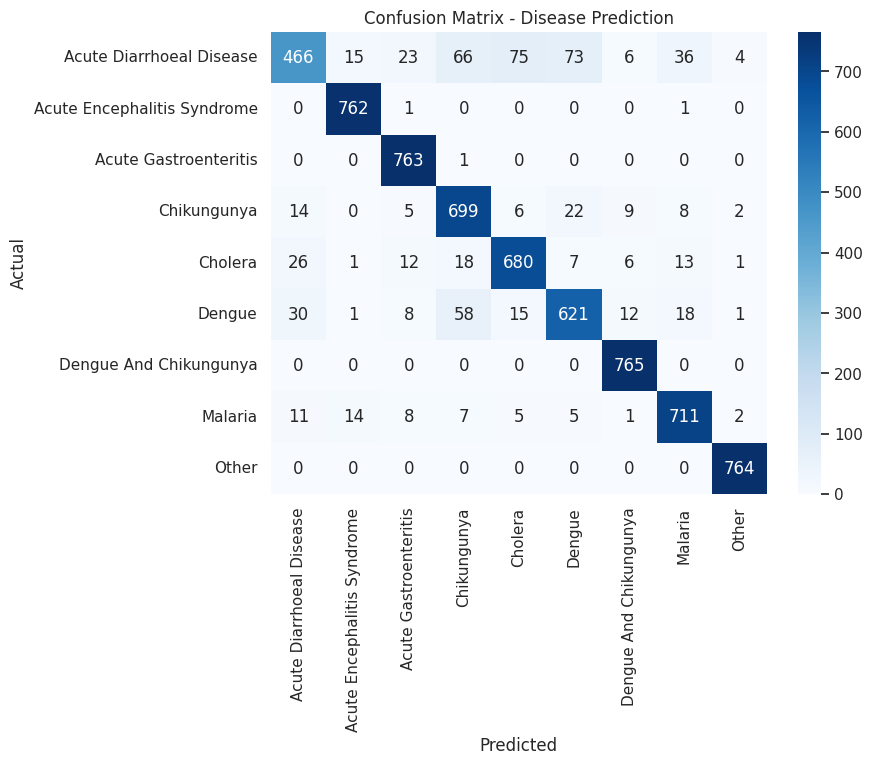

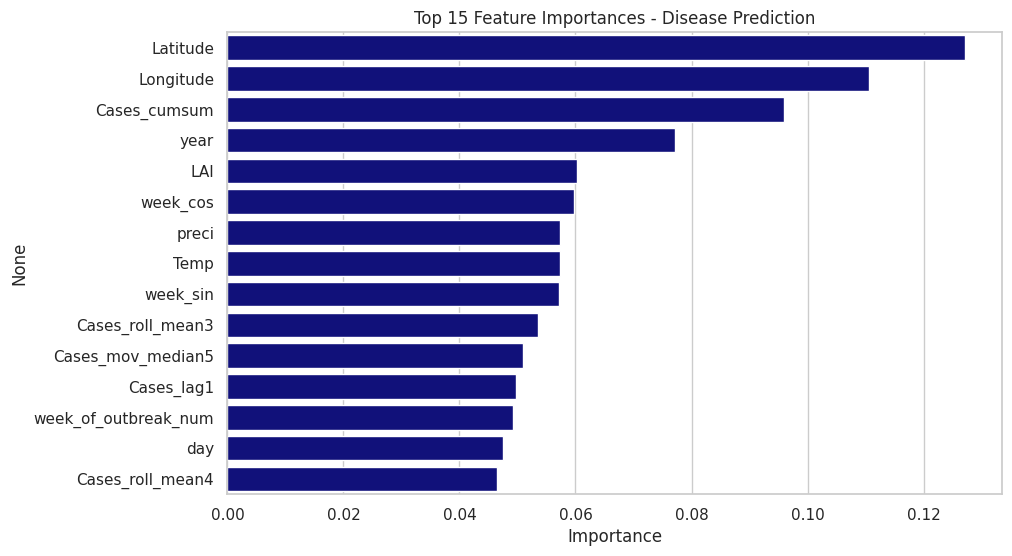

In [70]:
# ---------------------------
# Use top features from Feature Selection
# ---------------------------
X_disease_final = X_disease_res[top_disease_features.index]
y_disease_final = y_disease_res

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_disease_final, y_disease_final, test_size=0.2, random_state=42, stratify=y_disease_final
)

# ---------------------------
# Train RandomForest Classifier
# ---------------------------
rf_disease = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    class_weight="balanced",
    random_state=42
)
rf_disease.fit(X_train, y_train)

# ---------------------------
# Predictions & Evaluation
# ---------------------------
y_pred = rf_disease.predict(X_test)

print(" Disease Prediction Results")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_disease.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_disease.classes_,
            yticklabels=rf_disease.classes_)
plt.title("Confusion Matrix - Disease Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------------
# Feature Importance
# ---------------------------
disease_importances = pd.Series(rf_disease.feature_importances_, index=X_disease_final.columns)
top_imp = disease_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_imp.values, y=top_imp.index, color="darkblue")
plt.title("Top 15 Feature Importances - Disease Prediction")
plt.xlabel("Importance")
plt.show()




**Location Prediction(State) Model**

 States kept: 30 | Removed rare states: 3
 State Prediction Results
                        precision    recall  f1-score   support

        Andhra Pradesh       1.00      1.00      1.00        47
     Arunachal Pradesh       0.92      1.00      0.96        12
                 Assam       0.98      0.98      0.98        58
                 Bihar       1.00      0.98      0.99        62
            Chandigarh       1.00      1.00      1.00         8
          Chhattisgarh       1.00      0.98      0.99        60
Dadra and Nagar Haveli       1.00      0.50      0.67         2
                 Delhi       1.00      0.67      0.80         3
                   Goa       1.00      1.00      1.00         2
               Gujarat       0.97      0.99      0.98        71
               Haryana       0.90      0.64      0.75        14
      Himachal Pradesh       0.93      1.00      0.96        13
     Jammu and Kashmir       1.00      1.00      1.00        13
             Jharkhand       1.00  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


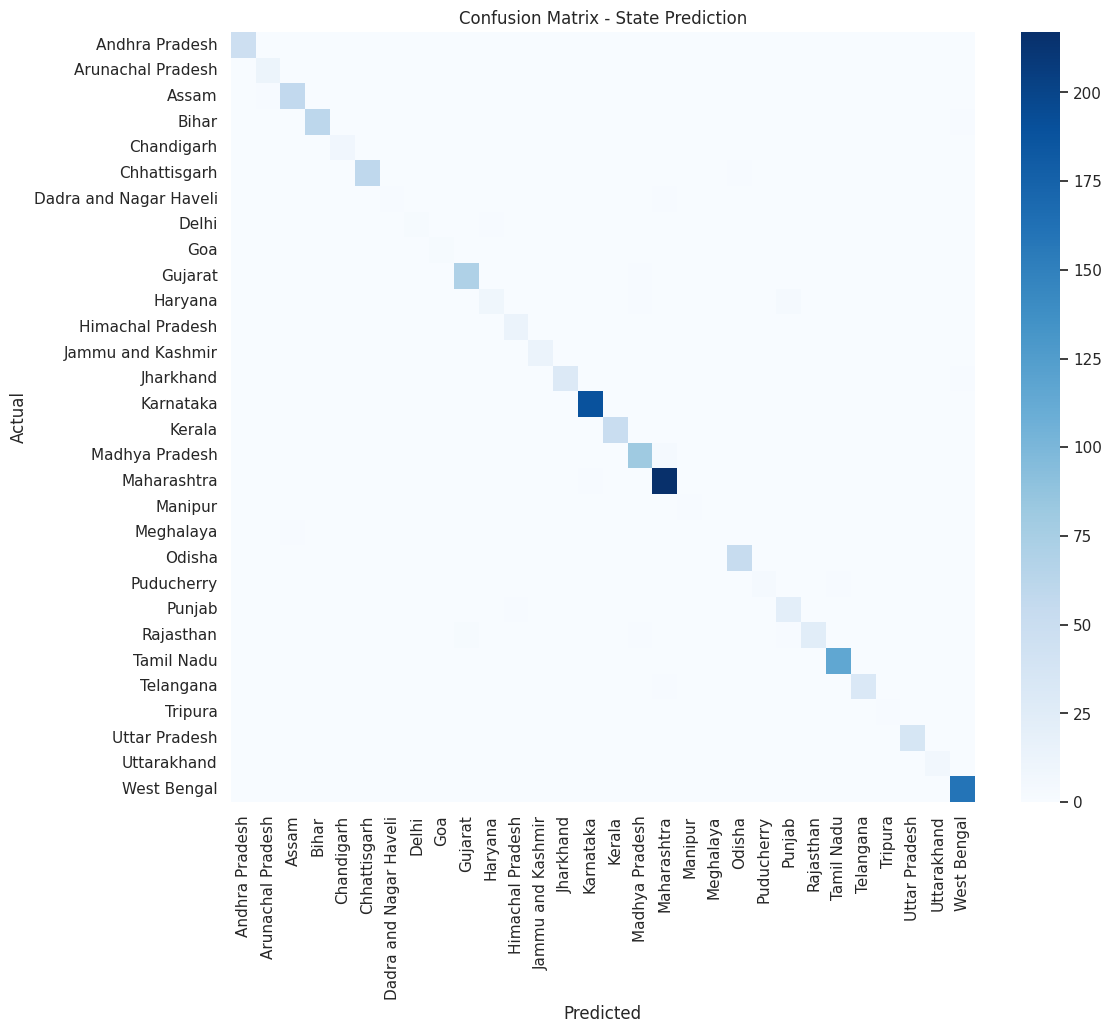

In [71]:
# ---------------------------
# Remove rare states (<2 samples)
# ---------------------------
state_counts = y_state.value_counts()
rare_states = state_counts[state_counts < 2].index

mask = ~y_state.isin(rare_states)
X_state_final = X_loc[top_state_features.index][mask]
y_state_final = y_state[mask]

print(f" States kept: {y_state_final.nunique()} | Removed rare states: {len(rare_states)}")

# ---------------------------
# Train-test split (now safe to stratify)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_state_final, y_state_final,
    test_size=0.2, random_state=42, stratify=y_state_final
)

# ---------------------------
# Train RandomForest Classifier
# ---------------------------
rf_state = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_state.fit(X_train, y_train)

# ---------------------------
# Predictions & Evaluation
# ---------------------------
y_pred = rf_state.predict(X_test)

print(" State Prediction Results")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_state.classes_)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues",
            xticklabels=rf_state.classes_,
            yticklabels=rf_state.classes_)
plt.title("Confusion Matrix - State Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Final Result**

 Final Results Summary
                                  Task                         Metric
0        Cases Prediction (Regression)       RMSE: 0.1466, R²: 0.9786
1  Disease Prediction (Classification)  Accuracy: 91%, Macro F1: 0.90
2    State Prediction (Classification)  Accuracy: 98%, Macro F1: 0.89


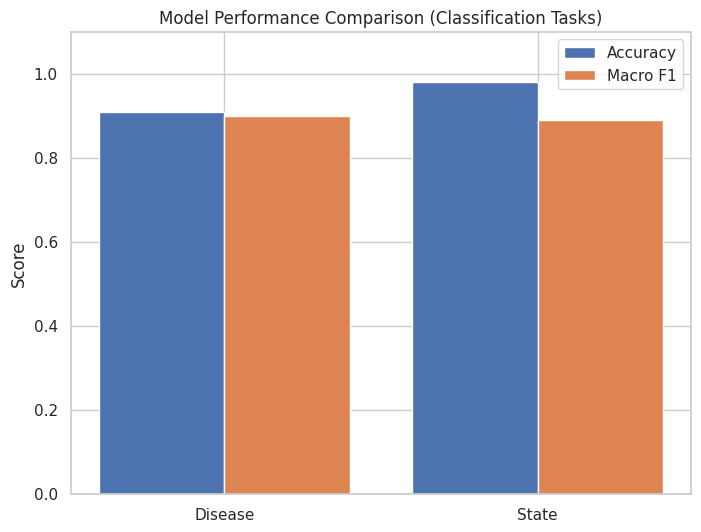

In [73]:
# ---------------------------
# 1. Collect Final Results
# ---------------------------
results = {
    "Task": [
        "Cases Prediction (Regression)",
        "Disease Prediction (Classification)",
        "State Prediction (Classification)"
    ],
    "Metric": [
        "RMSE: 0.1466, R²: 0.9786",
        "Accuracy: 91%, Macro F1: 0.90",
        "Accuracy: 98%, Macro F1: 0.89"
    ]
}

df_results = pd.DataFrame(results)

print(" Final Results Summary")
print(df_results)

# ---------------------------
# 2. Bar Plot for Accuracy/F1 Comparison
# ---------------------------
classification_results = {
    "Task": ["Disease", "State"],
    "Accuracy": [0.91, 0.98],   # from your reports
    "Macro_F1": [0.90, 0.89]    # from macro avg f1
}
df_cls = pd.DataFrame(classification_results)

# Plot grouped bar chart
plt.figure(figsize=(8,6))
x = range(len(df_cls))
plt.bar([p - 0.2 for p in x], df_cls["Accuracy"], width=0.4, label="Accuracy")
plt.bar([p + 0.2 for p in x], df_cls["Macro_F1"], width=0.4, label="Macro F1")

plt.xticks(x, df_cls["Task"])
plt.ylim(0,1.1)
plt.ylabel("Score")
plt.title("Model Performance Comparison (Classification Tasks)")
plt.legend()
plt.show()


**Saving Models**

In [74]:
# Save preprocessors
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "encoder.pkl")

# Save models
joblib.dump(xgb_model, "model_cases.pkl")
joblib.dump(rf_disease, "model_disease.pkl")
joblib.dump(rf_state, "model_state.pkl")



['model_state.pkl']

In [75]:
joblib.dump(top_cases_features.index.tolist(), "cases_features.pkl")
joblib.dump(top_state_features.index.tolist(), "state_features.pkl")
joblib.dump(top_disease_features.index.tolist(), "disease_features.pkl")


['disease_features.pkl']